In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
# === Configuration === #
AUDIO_FOLDER = "D:/FYP/Datasets/Paper sourced/SegmentedAudio_HolybroS500"  # Folder containing drone audio files
RESULTS_CSV = "drone_spl_results.csv"  # Output CSV file
SPL_RESULTS_FOLDER = "D:/FYP/Datasets/Paper sourced/SPL_Results"  # Folder to store SPL vs. time CSVs
os.makedirs(SPL_RESULTS_FOLDER, exist_ok=True)  # Ensure folder exists

In [10]:
# === Microphone & ADC Specifications (Behringer Setup) === #
MIC_SENSITIVITY_MV_PA = 22  # 22 mV/Pa for Behringer C-1
V_MAX = 0.98  # Max voltage input to ADC
P_REF = 20e-6  # Reference pressure in air (20 µPa)
BIT_DEPTH = 16  # 16-bit ADC
SR_TARGET = 16000  # Standard sample rate
FRAME_LENGTH = 0.05  # 50ms frames
HOP_LENGTH = 0.01  # 10ms hop

In [11]:
# === Function to Compute and Store SPL Metrics === #
def compute_spl(file_path, plot_reference=False):
    try:
        # Load audio using librosa
        audio_signal, sr = librosa.load(file_path, sr=SR_TARGET)

        # Scale back to original integer range
        audio_signal = audio_signal * (2**(BIT_DEPTH - 1))

        # === Compute RMS SPL over time === #
        frame_size = int(sr * FRAME_LENGTH)
        hop_size = int(sr * HOP_LENGTH)
        rms_values = librosa.feature.rms(y=audio_signal, frame_length=frame_size, hop_length=hop_size)[0]
        time_axis = librosa.times_like(rms_values, sr=sr, hop_length=hop_size)

        # Convert RMS values to SPL
        P_mic_rms = (rms_values * V_MAX) / ((2**(BIT_DEPTH - 1)) * (MIC_SENSITIVITY_MV_PA * 1e-3))
        SPL_rms = 20 * np.log10(P_mic_rms / P_REF)

        # Save SPL vs. Time Data to CSV
        output_csv_path = os.path.join(SPL_RESULTS_FOLDER, f"{os.path.basename(file_path).replace('.wav', '_spl.csv')}")
        df_spl = pd.DataFrame({"Time (s)": time_axis, "SPL (dB)": SPL_rms})
        df_spl.to_csv(output_csv_path, index=False)

        # === Plot SPL vs Time Graph (Only for First File) === #
        if plot_reference:
            plt.figure(figsize=(10, 5))
            plt.plot(time_axis, SPL_rms, label="SPL (dB)", color="b", linewidth=2)
            plt.xlabel("Time (seconds)")
            plt.ylabel("Sound Pressure Level (dB SPL)")
            plt.title(f"SPL vs. Time for {os.path.basename(file_path)}")
            plt.grid()
            plt.legend()
            plt.show()

        return os.path.basename(file_path), np.max(SPL_rms), np.mean(SPL_rms), output_csv_path

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return os.path.basename(file_path), None, None, None

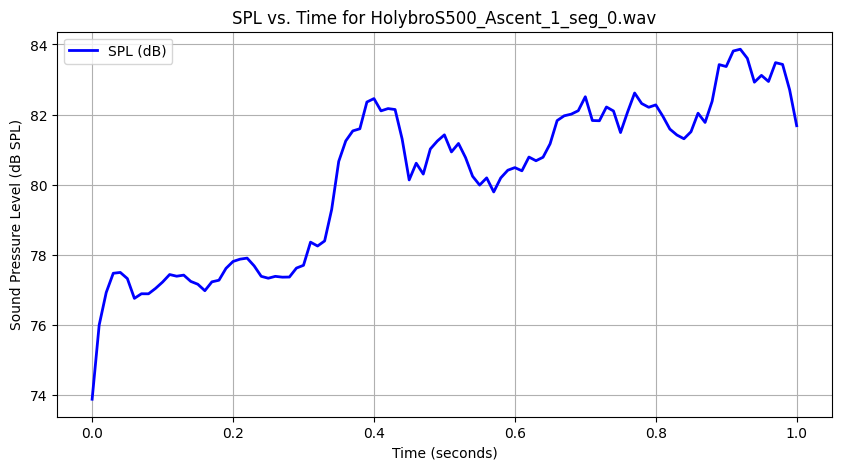

Results saved to drone_spl_results.csv


In [12]:
# === Process Multiple Audio Files === #
results = []
first_file = True
for file in os.listdir(AUDIO_FOLDER):
    if file.endswith(".wav"):  # Process only .wav files
        file_path = os.path.join(AUDIO_FOLDER, file)
        results.append(compute_spl(file_path, plot_reference=first_file))
        first_file = False  # Only plot the first file

# === Save Summary Results to CSV === #
df_summary = pd.DataFrame(results, columns=["File Name", "Max SPL (dB)", "Mean SPL (dB)", "SPL Data File"])
df_summary.to_csv(RESULTS_CSV, index=False)

print(f"Results saved to {RESULTS_CSV}")
